# Improving a Portuguese Bank's Direct Marketing Campaigns

The following [dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) is all of the instances and 17 of 29 attributes used for a data mining project conducted by university researchers [Moro et al., 2014]. The subject was a Portuguese bank's direct marketing program and their goal was to increase efficiency by reducing the number of calls made per conversion.

The research team explored how 3 data mining predictive models could learn about 17 recent marketing campaigns for a long-term deposit product to help the bank decide a course of action to achieve their goals.

I am not a machine learning algorithm, but I have everything I need to compete! This dataset was randomly split 2/3 to train and 1/3 to test and the most relevant attributes are retained.

## The problem
So, the bank wants the call center to make less calls per conversion? I don't blame them. The associated paper cites an influential study for the industry which found that direct marketing may trigger negative attitudes towards banks due to the intrusion of privacy (Page and Luding 2003). Also, as a long-running enterprise, this bank has the market traction that requires consistent progress towards this end.

## Hypothesis EDA for a potential solution
The dataset has several measured attributes (variables) which detail the rollout of the advertising campaign. Let's explore the key set of variables over which the call center has control.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
path = 'https://raw.githubusercontent.com/antdevelopment/Thinkful-Data-Science-Course/master/prep-course/capstone/bank-full.csv'
campaigns = pd.read_csv(path, sep=';')
campaigns.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Intro to measured variables (attributes)
The bank call center employees called clients to complete an outcome of interest. This outcome was to signup clients for the savings product over the phone, what I call the "signup outcome." This variable is in the final column of the above table, labeled "y". They were so serious about it that we have 17 campaigns of information spanning 2 and a half years! Thankfully, the researchers already cleaned up occurrencs of multiple records about the same client and retained the most recent record for each.

The employees also measured variables such as call date, call duration, number of times the client was called during the active campaign, and number of times the client was contacted during the prior campaign. These variables are clustered towards the 2nd half of the table. The rest of the variables have too much unknown information or are just demographic information, some of which also have too much unknown information.

I will explore the former variables.

### Cleaning and feature engineering

The dataset uses "yes" and "no" text values for binary attributes, uses text representations of months, and does not include the year portion of date information. Below, the months and binary attributes are converted to integer dummy variables to simplify programming.

In [3]:
# Creating month and signup dummy variable dataframe
keys = np.concatenate((campaigns.month.unique(), campaigns.y.unique()))
values = np.array([[5, 6, 7, 8, 10, 11, 12, 1, 2, 3, 4, 9, 0, 1]])
key_pairs = pd.DataFrame(data=values, columns=keys)

# Converting binary variables into dummy integer variables
campaigns[['y', 'month']] = campaigns[['y', 'month']].applymap(lambda item: key_pairs[item][0])

I chose a visual method of discovering the indices for the beginning of each year, the 1st year being 2008. The visualization below is representative of the plot I used to discover the indices and construct the year attribute.

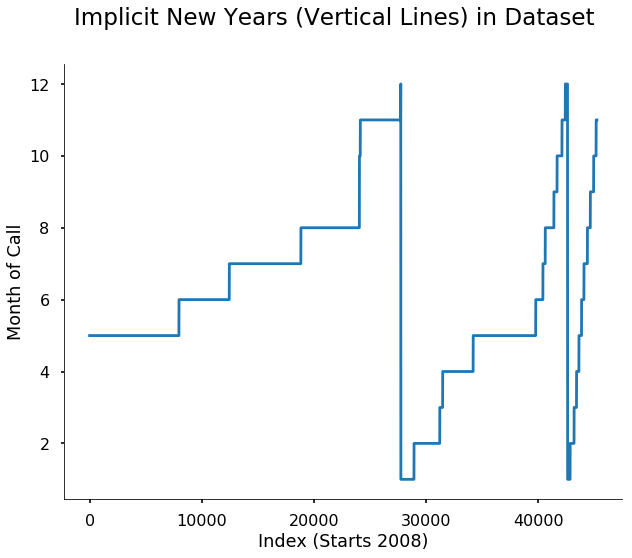

In [15]:
# Visually discover where each new year begins
sns.set_context('poster')
plt.figure(1, figsize=(10, 8))
plt.suptitle('Implicit New Years (Vertical Lines) in Dataset')
plt.plot(campaigns.index, campaigns.month)
sns.despine()
plt.xlabel('Index (Starts 2008)')
plt.ylabel('Month of Call')
plt.show()

# Year locations based on line plot EDA
## 2008 ends in December on index 27728, ~61% of the data
year_08 = np.array([2008] * 27729)

## 2009 begins in January at 27729 and ends in December at 42590, ~33% of the data
year_09 = np.array([2009] * 14862)

## 2010 begins in January at 42591 and ends in November at 45210, ~6% of the data
year_10 = np.array([2010] * 2620)

# New year and date variables
campaigns['year'] = np.append(np.append(year_08, year_09), year_10)
campaigns['date'] = campaigns.apply(lambda row: pd.Timestamp(row['year'], row['month'], row['day']), axis=1)

In [5]:
# Showing the sizes of the signup groups
print('The number of people who didn\'t sign up was:')
print(campaigns.y.value_counts()[0])
print()
print('The number of people who did sign up was:')
print(campaigns.y.value_counts()[1])

The number of people who didn't sign up was:
39922

The number of people who did sign up was:
5289


The yes group is nearly an order of magnitude smaller than the no group. Also, 2008 has almost 2/3 of the data. This may create problems during visualization and hypothesis analysis because of noise, like extreme but plausible values.

The continuous variables will be 90% Winsorized to filter out these issues. Therefore, all values below the 5th percentile will be reassigned to it and the same follows for values above the 95th percentile. It shall be noted that this will affect the means, the extent to which is outputted below.

The variable chosen for the experiment will be analyzed with respect to time in order to inform the design of the experiment. This will be done with the hope to uncover a perspective with less noise and less vulnerability to Simpson's Paradox.

To aid in the experimentation and analysis, I will also analyze the outcome with respect to time and call it "signup ratio." This is just the proportion of signups to all outcomes, but the period of time has to be specified. So the range of its values are between 0 and 1.

In [6]:
# "Winsorizations"
## Contact duration
print('The mean call duration before Winsorization is {}'.format(campaigns.duration.mean()))
campaigns.loc[campaigns.duration > campaigns.duration.quantile(.95), 'duration'] = campaigns.duration.quantile(.95)
campaigns.loc[campaigns.duration < campaigns.duration.quantile(.05), 'duration'] = campaigns.duration.quantile(.05)
print('The mean call duration after Winsorization is {}'.format(campaigns.duration.mean()), '\n')

## Amount of times contacted during this campaigns
print('The mean number of calls to each client before Winsorization is {}'.format(campaigns.campaign.mean()))
campaigns.loc[campaigns.campaign > campaigns.campaign.quantile(.95), 'campaign'] = campaigns.campaign.quantile(.95)
campaigns.loc[campaigns.campaign < campaigns.campaign.quantile(.05), 'campaign'] = campaigns.campaign.quantile(.05)
print('The mean number of calls to each client after Winsorization is {}'.format(campaigns.campaign.mean()), '\n')

## Amount of times contacted during the previous campaigns
print('The mean number of calls to each client in a previous campaign before Winsorization is {}'.format(campaigns.previous.mean()))
campaigns.loc[campaigns.previous > campaigns.previous.quantile(.95), 'previous'] = campaigns.previous.quantile(.95)
campaigns.loc[campaigns.previous < campaigns.previous.quantile(.05), 'previous'] = campaigns.previous.quantile(.05)
print('The mean number of calls to each client in a previous campaign after Winsorization is {}'.format(campaigns.previous.mean()))

# Splitting outcomes into two dataframes
no_signup = campaigns.loc[campaigns.y==0]
yes_signup = campaigns.loc[campaigns.y==1]

The mean call duration before Winsorization is 258.1630797814691
The mean call duration after Winsorization is 242.22078697662073 

The mean number of calls to each client before Winsorization is 2.763840658246887
The mean number of calls to each client after Winsorization is 2.511512684966048 

The mean number of calls to each client in a previous campaign before Winsorization is 0.5803233726305546
The mean number of calls to each client in a previous campaign after Winsorization is 0.3786910265200947


### Analytical visualizations of measured variables against signup outcome
#### Call duration

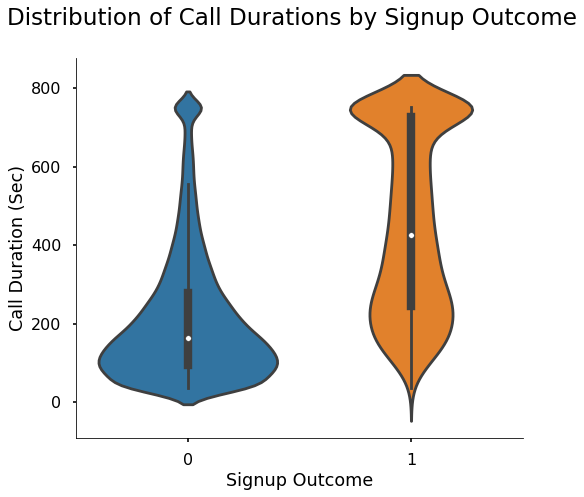

In [7]:
# Violin plot of duration by signup outcome
sns.set_context('poster')
plt.figure(2, figsize=(8, 7))
sns.violinplot(data=campaigns, x='y', y='duration')
sns.despine()
plt.xlabel('Signup Outcome')
plt.ylabel('Call Duration (Sec)')
plt.suptitle('Distribution of Call Durations by Signup Outcome')
plt.show()

The stark relationship on display here is that the median call duration for clients who signed up is over twice that of those who did not. The more ridiculous fact is that there is a cluster of data near the high 1.5 IQR of the group who signed up as a result of the 'winsorization," which indicates that there are many datapoints beyond 1.5IQR. These groups are truly different.
#### Date of contact

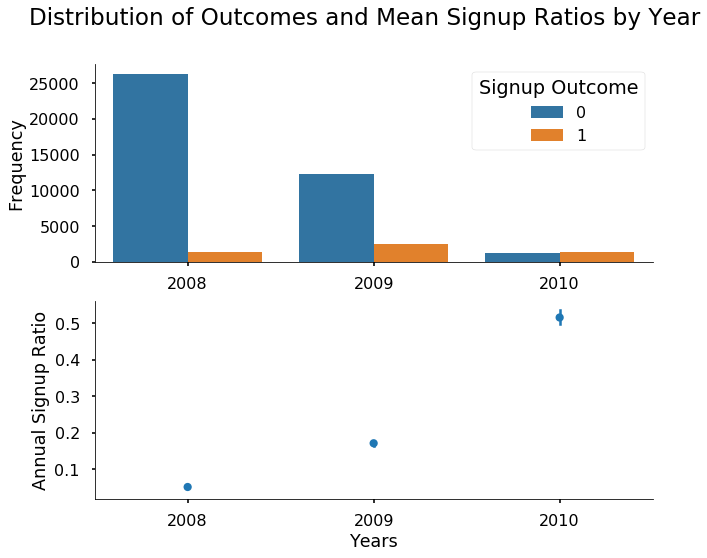

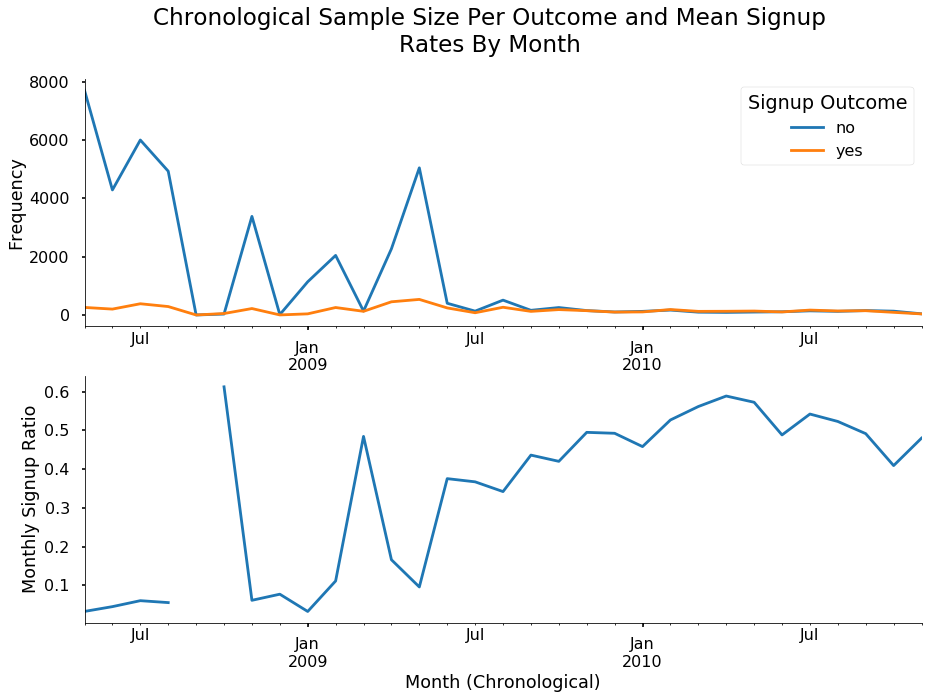

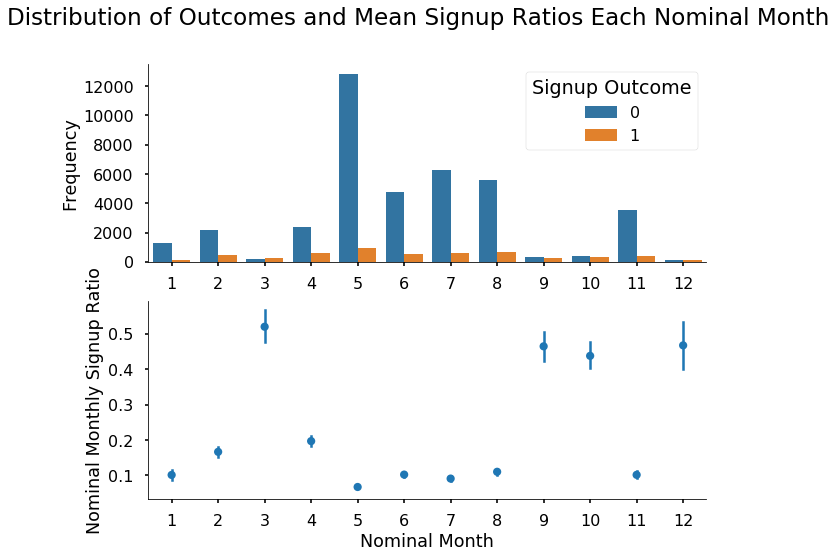

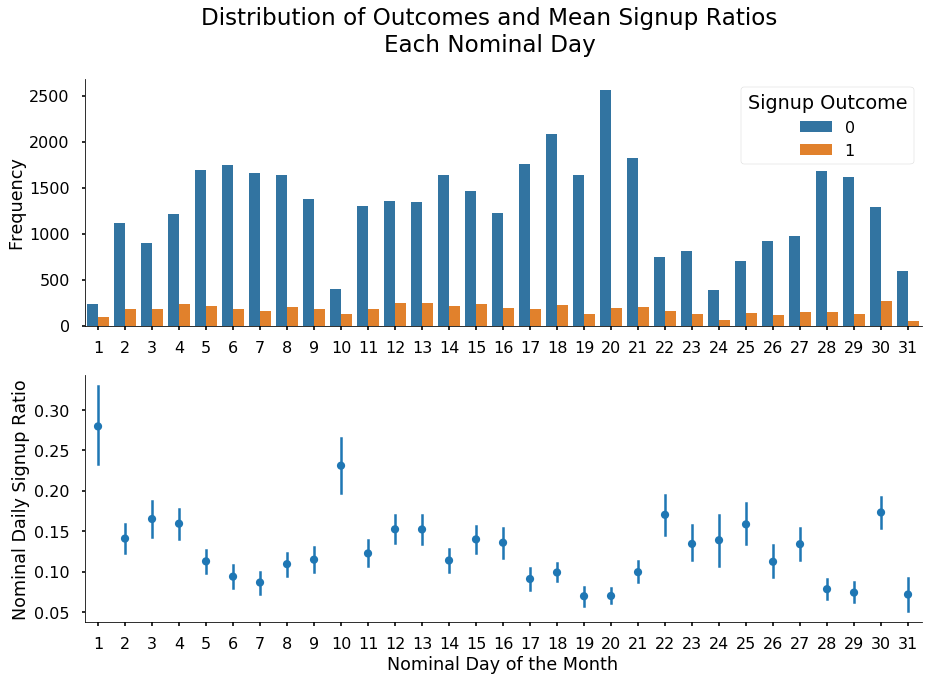

In [8]:
# Distribution then central tendency of signups by contact year
sns.set_context('poster')
plt.figure(3, figsize=(10, 8))
plt.suptitle('Distribution of Outcomes and Mean Signup Ratios by Year')
plt.subplot(211)
sns.countplot(x='year', data=campaigns, hue='y')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
sns.set_context('paper')
sns.pointplot(x='year', data=campaigns, y='y', join=False)
sns.despine()
plt.xlabel('Years')
plt.ylabel('Annual Signup Ratio')
plt.show()

# Chronological sample sizes and mean signup Ratios per month
sns.set_context('poster')
plt.figure(4, figsize=(15, 10))
plt.suptitle('Chronological Sample Size Per Outcome and Mean Signup\nRates By Month')
plt.subplot(211)
no_signup.set_index('date', inplace=False).groupby(pd.TimeGrouper(freq='M')).count().y.plot(label='no')
yes_signup.set_index('date', inplace=False).groupby(pd.TimeGrouper(freq='M')).count().y.plot(label='yes')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
campaigns.set_index('date', inplace=False).groupby(pd.TimeGrouper(freq='M')).mean().y.plot()
sns.despine()
plt.xlabel('Month (Chronological)')
plt.ylabel('Monthly Signup Ratio')
plt.show()

# Distribution then central tendency of signups by contact month
sns.set_context('poster')
plt.figure(5, figsize=(10, 8))
plt.suptitle('Distribution of Outcomes and Mean Signup Ratios Each Nominal Month')
plt.subplot(211)
sns.countplot(x='month', data=campaigns, hue='y')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
sns.set_context('paper')
sns.pointplot(x='month', data=campaigns, y='y', join=False)
sns.despine()
plt.xlabel('Nominal Month')
plt.ylabel('Nominal Monthly Signup Ratio')
plt.show()

# Distribution then central tendency of signups by contact day of month
sns.set_context('poster')
plt.figure(6, figsize=(15, 10))
plt.suptitle('Distribution of Outcomes and Mean Signup Ratios\nEach Nominal Day')
plt.subplot(211)
sns.countplot(x='day', data=campaigns, hue='y')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
sns.set_context('paper')
sns.pointplot(x='day', data=campaigns, y='y', join=False)
sns.despine()
plt.xlabel('Nominal Day of the Month')
plt.ylabel('Nominal Daily Signup Ratio')
plt.show()

The overall pattern I observe over these time-based visualizations is that lower signup ratios are associated with larger amounts of datapoints, regardless of the unit of time. Remember, some clients were called multiple times during this 2 and a half year period. A datapoint in this dataset was generated only when the client was never called again. For instance, 2008 is the year with the most datapoints, and May 2009 is the month with the most datapoints for 2009. 2008 has the lowest signup ratio and May 2009 is 2nd place.

However, 2010 only has 6% of the data but knocks it out of the park with almost every month near 50% signup ratio. Additionally, The signup ratios look similar in 2009 starting in November. This is probably why 2010 has a signup ratio an order of magnitude higher than 2008 and 2009 is 3x higher. I believe confounding  variables arrived on the scene by November 2009, causing a slower rate of datapoint generation. It shall be noted that the researchers had to clean the dataset, including removing missing values, shrinking the set from 79354 down to 45211. It was not revealed in the paper where in time these values mostly resided.

Lets trim off November 2009 and beyond, then plot the nominal information again.

In [9]:
# New dataframe up to Oct 30, 2009 to remove 
campaigns_to_Oct09 = campaigns[campaigns.date < '2009-11-1']

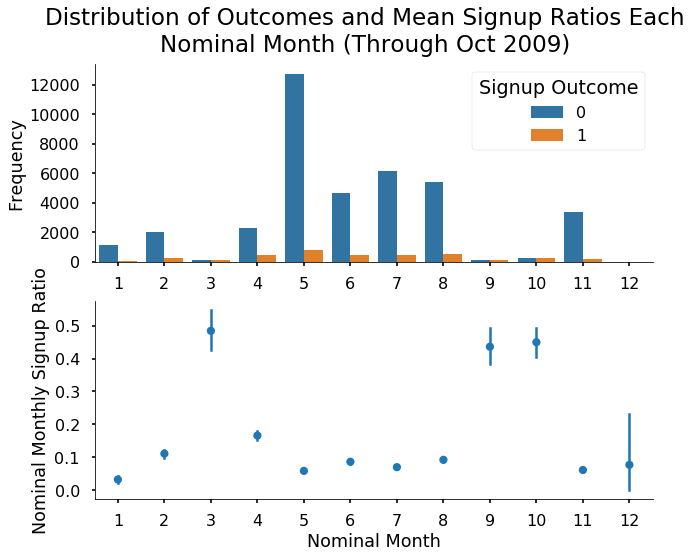

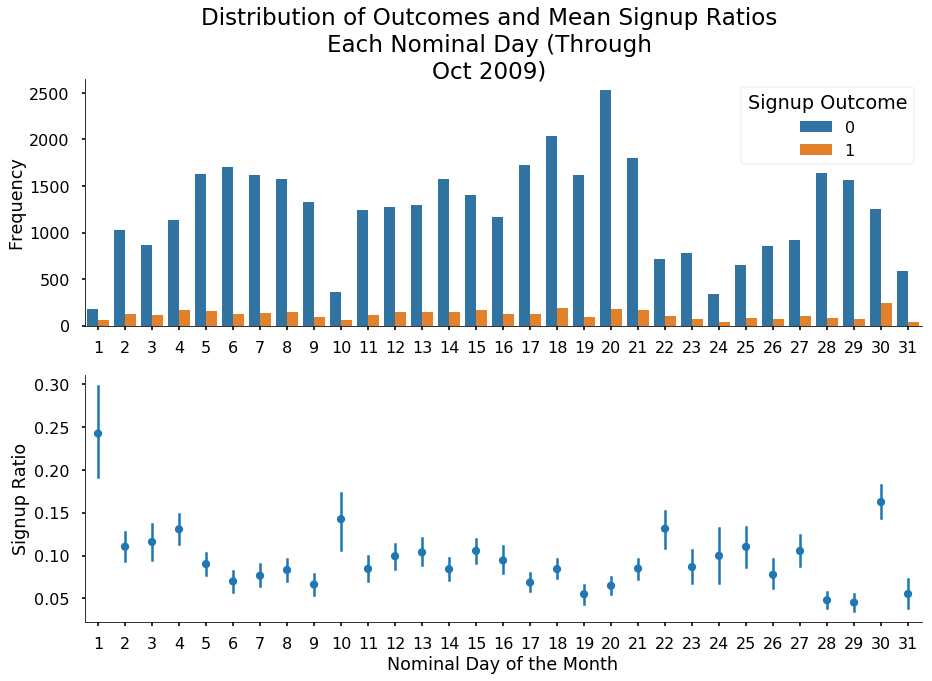

In [10]:
# Distribution then central tendency of signups by nominal contact month
sns.set_context('poster')
plt.figure(5, figsize=(10, 8))
plt.suptitle('Distribution of Outcomes and Mean Signup Ratios Each\nNominal Month (Through Oct 2009)')
plt.subplot(211)
sns.countplot(x='month', data=campaigns_to_Oct09, hue='y')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
sns.set_context('paper')
sns.pointplot(x='month', data=campaigns_to_Oct09, y='y', join=False)
sns.despine()
plt.xlabel('Nominal Month')
plt.ylabel('Nominal Monthly Signup Ratio')
plt.show()

# Distribution then central tendency of signups by nominal day of month
sns.set_context('poster')
plt.figure(6, figsize=(15, 10))
plt.suptitle('Distribution of Outcomes and Mean Signup Ratios\nEach Nominal Day (Through\nOct 2009)')
plt.subplot(211)
sns.countplot(x='day', data=campaigns_to_Oct09, hue='y')
sns.despine()
plt.xlabel('')
plt.ylabel('Frequency')
plt.legend(title='Signup Outcome')
plt.subplot(212)
sns.set_context('paper')
sns.pointplot(x='day', data=campaigns_to_Oct09, y='y', join=False)
sns.despine()
plt.xlabel('Nominal Day of the Month')
plt.ylabel('Signup Ratio')
plt.show()

After trimming off datapoints beyond October 2009, we can see that the averages have dropped a few % in general, though dramatically for groups like nominal December. Yet still, the variation in the data has remained very similar. Afterall, this is almost 94% of the data.

Before and after the cleaning, nominal days remain the unit of time with the most comparable sample sizes and similar proportion of signups to the annual proportions. This is the unit of time which appears to be the least susceptible to noise and Simpson's Paradox.
#### Amount of calls

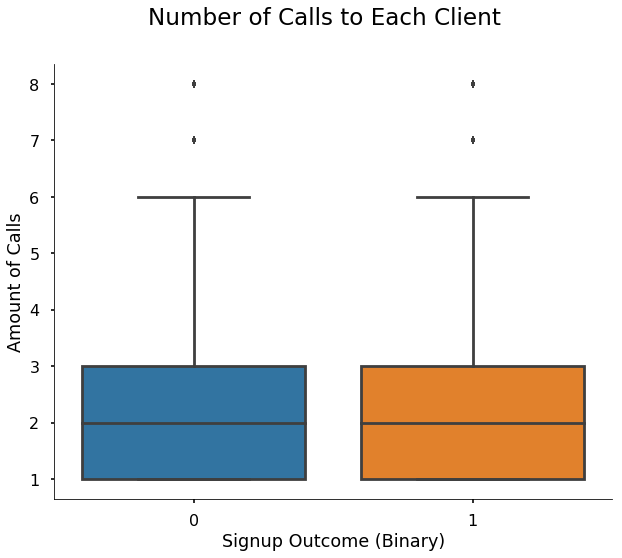

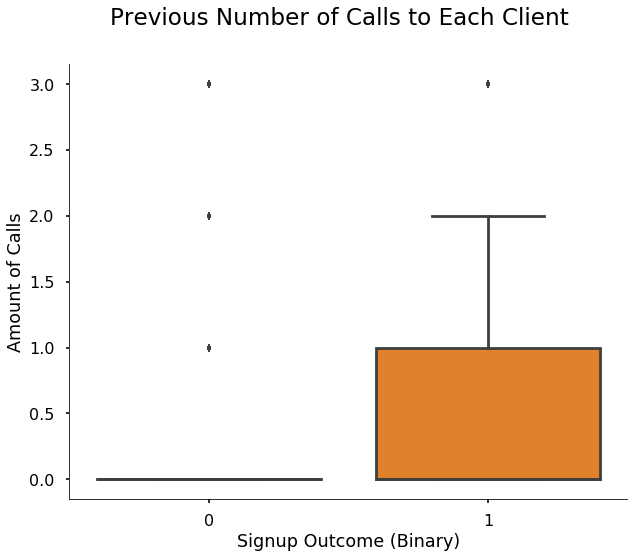

In [11]:
# Boxplot of times contacted by signup status
sns.set_context('poster')
plt.figure(6, figsize=(10, 8))
sns.boxplot(data=campaigns, x='y', y='campaign')
sns.despine()
plt.xlabel('Signup Outcome (Binary)')
plt.ylabel('Amount of Calls')
plt.suptitle('Number of Calls to Each Client')
plt.show()

# Boxplot of times contacted in previous campaigns by signup status
sns.set_context('poster')
plt.figure(7, figsize=(10, 8))
sns.boxplot(data=campaigns, x='y', y='previous')
sns.despine()
plt.xlabel('Signup Outcome (Binary)')
plt.ylabel('Amount of Calls')
plt.suptitle('Previous Number of Calls to Each Client')
plt.show()

There isn't much to mention here. Only the most intelligent of machine learning algorithms could possibly uncover a pattern from these variables.

### Possible solution
Duration, when viewed in aggregate over the whole dataset, appeared to be the most useful predictor of the signup outcome. Let's see if this pattern survives chronological forces through October 2009.

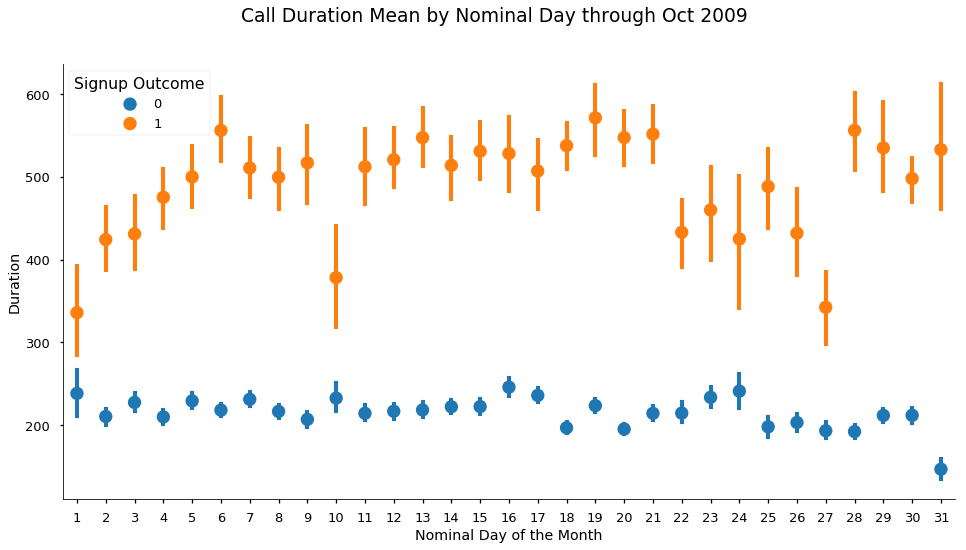

In [12]:
# Central tendency of duration by nominal day called denominated by signup outcome
sns.set_context('talk')
plt.figure(8, figsize=(16, 8))
plt.suptitle('Call Duration Mean by Nominal Day through Oct 2009')
sns.despine()
sns.pointplot(x='day', data=campaigns_to_Oct09, y='duration', hue='y', join=False)
sns.despine()
plt.xlabel('Nominal Day of the Month')
plt.ylabel('Duration')
plt.legend(title='Signup Outcome', loc=2)
plt.show()

Duration does survive the times. There is a high association between duration and signups. The hypothesis is that a longer call duration leads to signups.

The potential solution is for the call center to aim to lengthen conversations with clients.

## Testing the solution

### Design of the experiment
The outcome being tracked per call is binary - did the client signup for the product over the phone? However, we are comparing this experiment's data to the signup ratio per nominal day from the prior experiment. So the outcome variable is this variable, which will be calculated from the tracked outcomes.

The goal of the experiment is to measure the effect of a policy/benchmark on the outcome. Therefore, the treatment is that call center employees will operate under a policy of longer conversations. The reason is that the call duration is not known before the call takes place.

There are also other variables of interest. The call center representatives will ask for updates on the demographic records, which will allow us to observe the similarities of the populations after the experiment is complete. They will also record the call duration. And, for goodness' sake, they will record the year!

#### Rollout
Sampling and assignment will be handled as follows:
1. The target audience of clients for the new marketing campaign will not be randomly selected but determined by the team that normally owns this function. The sample size should be large enough based on the characteristics of this dataset.
2. The call center employees will be randomly split into control and treatment teams.
3. The clients will be randomly split into 2 groups
    a. One group assigned to control/treatment randomly with a 10% chance of treatment
    b. The other group assigned to control/treatment randomly with a 50% chance of treatment

The experiment will commence in April because this dataset is highly clustered between April and August. It will also begin with a partial assignment of treatment, at 10% for a month, to allow strategy tuning. Only after a month will 50% of clients be called under the policy of longer conversation.

### Analysis
The signup ratio for each day of the month will be calculated for each group. After 2 months, the signup ratio for each day will be averaged if it repeated. These averages will be compared to the corresponding averages in this dataset.

### Evaluation and benchmarks
If 90% of the calendar days in 2 months have x% increase in signup ratio over this campaign, conclude longer calls increase signup ratio. If the increase in these days is less than 1 quartile larger, observe for 2 more months. If signup ratio doesn't increase in 2 months, stop intentionally lengthening calls.